In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
dd_data = pd.read_csv('data_experiencedT/DD_ProcessedComplete.csv')

# For all countries get the Year 2018 and DD_type CDD18
dd_data = dd_data.loc[(dd_data['Year'] == 2018) & (dd_data['DD_type'] == 'CDD18')]
# Drop all columns except ISO3 and DD_mean
dd_data = dd_data[['ISO3', 'DD_mean']]
#Make ISO3 as index
dd_data = dd_data.set_index('ISO3')

In [3]:
# Open gdp nc file
gdp_data = pd.read_csv('data_experiencedT/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5871588.csv')
# Drop all columns except Country Code and 2018
gdp_data = gdp_data[['Country Code', '2018']]
# Rename Country Code to ISO3
gdp_data = gdp_data.rename(columns={'Country Code': 'ISO3'})
# Make ISO3 as index
gdp_data = gdp_data.set_index('ISO3')
# Rename 2018 to GDP
gdp_data = gdp_data.rename(columns={'2018': 'GDP'})


In [4]:
# Merge the two dataframes
merged_data = pd.merge(dd_data, gdp_data, on='ISO3')

In [5]:
def sat(cdd):
    return (1.00 - 0.949*np.exp(-0.00187*cdd))

infl_factor = 1.65
def avail(gdp):
    return (1/(1+np.exp(4.152)*np.exp(-0.237*infl_factor*gdp/1000)))

def exposure(gdp, cdd):
    return (1 - avail(gdp)*sat(cdd))

In [6]:
# Add AC column to merged_data
# source: https://www.iea.org/data-and-statistics/charts/percentage-of-households-equiped-with-ac-in-selected-countries-2018
merged_data['AC'] = np.nan
merged_data.loc[merged_data.index == 'JPN', 'AC'] = 0.91
merged_data.loc[merged_data.index == 'USA', 'AC'] = 0.9
merged_data.loc[merged_data.index == 'KOR', 'AC'] = 0.86
merged_data.loc[merged_data.index == 'SAU', 'AC'] = 0.63
merged_data.loc[merged_data.index == 'CHN', 'AC'] = 0.6
merged_data.loc[merged_data.index == 'MEX', 'AC'] = 0.16
merged_data.loc[merged_data.index == 'BRA', 'AC'] = 0.16
merged_data.loc[merged_data.index == 'IDN', 'AC'] = 0.09
merged_data.loc[merged_data.index == 'ZAF', 'AC'] = 0.06
merged_data.loc[merged_data.index == 'IND', 'AC'] = 0.05
# Save AC data as csv
merged_data.to_csv('data_experiencedT/AC_data.csv', index=True)

In [7]:
def read_ac_data(data_file):
    # Read in AC data
    ac_data = pd.read_csv(data_file)
    # Remove rows with missing data
    ac_data = ac_data.dropna()
    # Reindex
    ac_data = ac_data.reset_index(drop=True)
    return ac_data

ac_data = read_ac_data('data_experiencedT/AC_data.csv')

In [8]:
# Make a contour plot of penetration of air conditioning as a function of GDP per capita and cooling degree days
def exposure_contour(exposure_function, ac_data, add_data=True, contour_lines=False, name_tag='exposure_contour'):
    plt.figure()
    cdd_x = np.linspace(0, 3500, 100)
    gdp_x = np.linspace(0, 100000, 100)
    levels = np.linspace(0, 1, 21)
    cdd_x, gdp_x = np.meshgrid(cdd_x, gdp_x)
    plt.contourf(gdp_x, cdd_x, exposure_function(gdp_x, cdd_x), levels=levels)
    plt.colorbar(label='Exposure to outside temperatures', ticks=np.linspace(0, 1, 11))

    if contour_lines:
        # Add contour lines
        clines = plt.contour(gdp_x, cdd_x, exposure_function(gdp_x, cdd_x), levels=levels, colors='k', linewidths=0.)
        plt.clabel(clines, levels[::2], fmt='%1.2f', fontsize=8, colors='black')

    plt.xlabel('GDP per capita in 2018 USD')
    # GDP log scale
    plt.xscale('log')
    plt.xlim(1500, 100000)
    plt.ylabel('Cooling degree days')
    # color bar range is 0 to 1
    plt.clim(0, 1.0)
    # Add label in red and bold
    plt.title('Exposure to outside temperatures\n as a function of GDP and CDD')
    
    if add_data:
        # Overlay AC data
        # Plot AC access as a function of GDP per capita and cooling degree days
        plt.scatter(ac_data['GDP'], ac_data['DD_mean'], c=1.-ac_data['AC'], cmap='viridis', label='AC access')
        # Label points with country names
        for i, txt in enumerate(ac_data['ISO3'].values):
            plt.annotate(txt+"\n"+str(round(1.-ac_data['AC'][i],3)), (ac_data['GDP'][i]*1.05, ac_data['DD_mean'][i]-100), fontsize=8.5, color='white')

    plt.savefig('Figures/exposure_funct_analysis/{0}.png'.format(name_tag), dpi=300)

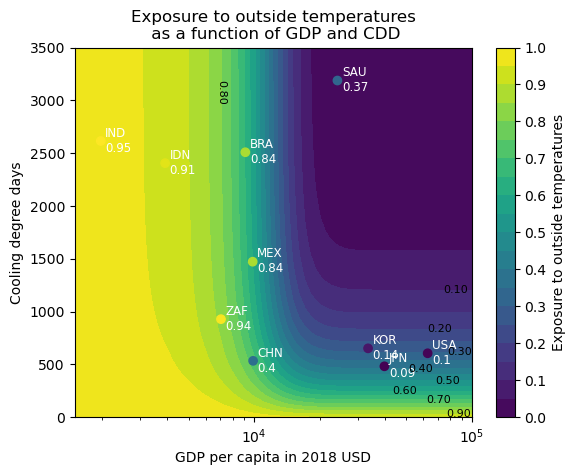

In [9]:
exposure_contour(exposure, ac_data, contour_lines=True, add_data=True)

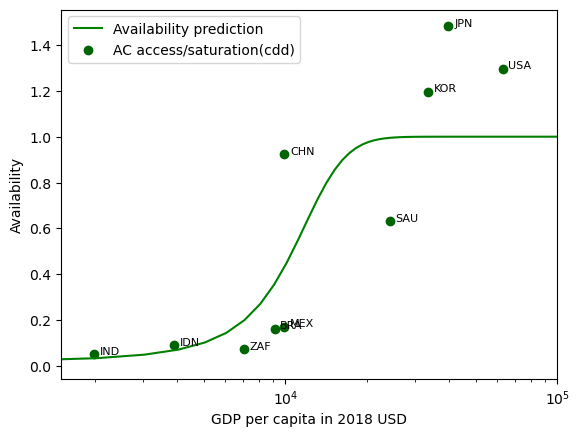

In [10]:
# Assuming saturation is true, plot availability as a function of GDP per capita
# Add column to AC data for saturation based on DD_mean
ac_data['sat_calc'] = sat(ac_data['DD_mean'])
# Compute availability as exposure/saturation
ac_data['avail_pred'] = ac_data['AC']/ac_data['sat_calc']
# Plot availability curve and data points
plt.close()
plt.figure()
gdp_x = np.linspace(0, 100000, 100)
plt.plot(gdp_x, avail(gdp_x), label='Availability prediction', color='green')
plt.scatter(ac_data['GDP'], ac_data['avail_pred'], label='AC access/saturation(cdd)', color='darkgreen')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred'][i]), fontsize=8)
plt.xlabel('GDP per capita in 2018 USD')
# GDP log scale
plt.xscale('log')
plt.xlim(1500, 100000)
plt.ylabel('Availability')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/availability.png', dpi=300)

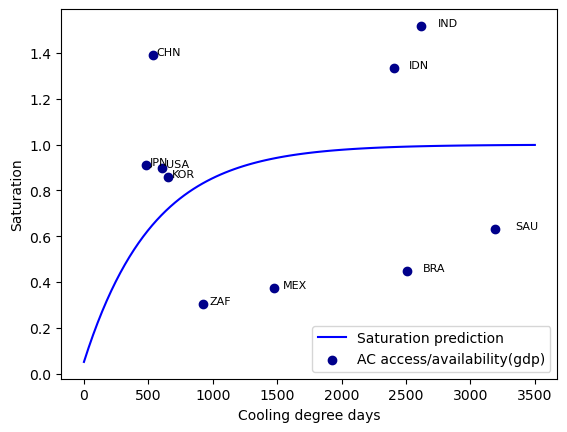

In [11]:
# Assuming availability is true, plot saturation as a function of cooling degree days
ac_data['avail_calc'] = avail(ac_data['GDP'])
# Compute saturation as exposure/availability
ac_data['sat_pred'] = ac_data['AC']/ac_data['avail_calc']
# Plot saturation curve and data points
plt.figure()
cdd_x = np.linspace(0, 3500, 100)
plt.plot(cdd_x, sat(cdd_x), label='Saturation prediction', color='blue')
plt.scatter(ac_data['DD_mean'], ac_data['sat_pred'], label='AC access/availability(gdp)', color='darkblue')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['DD_mean'][i]*1.05, ac_data['sat_pred'][i]), fontsize=8)
plt.xlabel('Cooling degree days')
plt.ylabel('Saturation')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/saturation.png', dpi=300)


In [12]:
# Derive functions from scratch
import openpyxl

# Read in US state data for AC 2020
us_data =  pd.read_excel('data_experiencedT/State Air Conditioning.xlsx', header=1, skiprows=3)
# Drop rows
us_data = us_data.drop(0)
# Drop all rows with nan
us_data = us_data.dropna()
# Reindex
us_data = us_data.reset_index(drop=True)
# First column is state name
us_data = us_data.rename(columns={'Unnamed: 0': 'State'})
# Set state as index
us_data = us_data.set_index('State')
# Drop first column
us_data = us_data.drop(columns=['Unnamed: 1'])
# Rename column Unnamed: 3 to AC and drop all other columns
us_data = us_data.rename(columns={'Unnamed: 3': 'AC'})
us_data = us_data [['AC']]
us_data[['AC']] = us_data[['AC']]/100.

# Strip whitespace from index
us_data.index = us_data.index.str.strip()
# Drop rows for Hawaii and Alaska
us_data = us_data[us_data.index != 'Hawaii']
us_data = us_data[us_data.index != 'Alaska']


In [13]:
# Read in US state data for DD 2020
state_cdd_data = pd.read_csv('data_experiencedT/heating-cooling_fig-3.csv', skiprows=6)
# Drop all rows except 2020
state_cdd_data = state_cdd_data.loc[state_cdd_data['Year/Trend'] == '2020']
state_cdd_data = state_cdd_data.drop(columns=['Year/Trend'])
# Transpose dataframe
state_cdd_data = state_cdd_data.T
# Rename index to State
state_cdd_data.index.name = 'State'
# Drop first row
state_cdd_data = state_cdd_data.rename(columns={126: 'CDD_mean'})
# Rename state names to full names instead of abbreviations
state_abbr_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
                     'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
                     'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
                     'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
                     'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
                     'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
                     'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin',
                     'WY': 'Wyoming'}
state_cdd_data.index = state_cdd_data.index.map(state_abbr_dict)

In [14]:
# Merge the two dataframes
us_state_cdd_AC_data = pd.merge(us_data, state_cdd_data, on='State')
# Save as csv
us_state_cdd_AC_data.to_csv('data_experiencedT/us_state_cdd_AC_data.csv', index=True)

In [15]:
# Plot AC access as a function of cooling degree days
def plot_saturation(normalize=False):
    plt.figure()
    plt.scatter(us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'], s=20, label='AC access in US states')
    plt.xlabel('Cooling degree days (65°F)')
    plt.ylabel('AC ownership')
    plt.title('AC access in US states in 2020')

    # Saturation function to fit to data
    def saturation_fit(cdd, a, b, c):
        return (a - b*np.exp(-c*cdd))

    # Add data point at 0, 0
    plt.scatter(0, 0., color='black', marker='o', s=20, label='No AC access (artificially added)')
    us_state_cdd_AC_data.loc[len(us_state_cdd_AC_data)] = {'CDD_mean': 0, 'AC': 0.}
    # Fit saturation function to data
    popt, pcov = curve_fit(saturation_fit, us_state_cdd_AC_data['CDD_mean'], us_state_cdd_AC_data['AC'], p0=(1, 1, 0.001))


    # Plot saturation function fit
    cdd_x_fine = np.linspace(0, 4500, 1000)
    plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt), label='Saturation fit', color='blue')
    plt.text(2200, 0.3, f'$sat(x) = {popt[0]:.2f} - {popt[1]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='blue', fontweight='bold')
    
    
    if normalize==True:
        # Normalize
        popt /= popt[0]
        # Normalize saturation function to 1
        plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt)/popt[0], label='Saturation fit normalized to 1 ', color='turquoise')
        plt.text(2200, 0.25, f'$sat_{{norm}}(x) = {popt[0]/popt[0]:.2f} - {popt[1]/popt[0]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='turquoise', fontweight='bold')
    elif normalize=='just_constant':
        popt[0] = 1.
        plt.plot(cdd_x_fine, saturation_fit(cdd_x_fine, *popt), label='Saturation fit with constant 1 ', color='turquoise')
        plt.text(2200, 0.25, f'$sat_{{norm}}(x) = {popt[0]:.2f} - {popt[1]:.2f}e^{{-{popt[2]:.3f}x}}$', fontsize=10, color='turquoise', fontweight='bold')

    plt.legend()
    plt.savefig('Figures/exposure_funct_analysis/us_state_AC.png', dpi=300)

    print(popt)
    sat_a, sat_b, sat_c = popt

    return sat_a, sat_b, sat_c

[0.93169464 0.92515973 0.00492885]


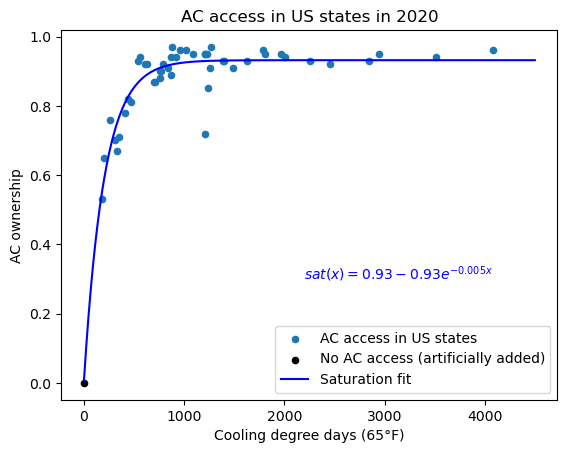

In [16]:
sat_a, sat_b, sat_c = plot_saturation(normalize=False)

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


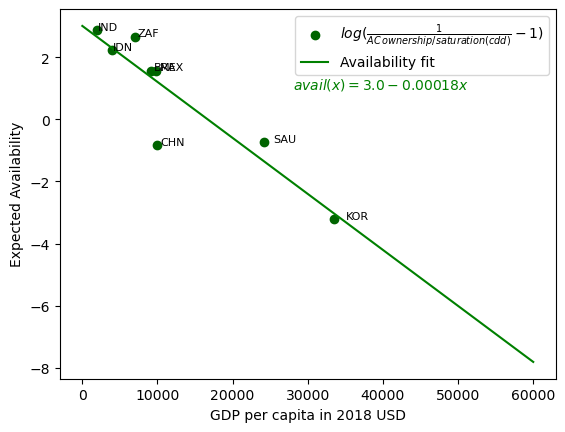

In [17]:
def saturation_new(cdd):
    return (sat_a - sat_b*np.exp(-sat_c*cdd))

ac_data['sat_calc_new'] = saturation_new(ac_data['DD_mean'])
# Compute availability as exposure/saturation
ac_data['avail_pred_new'] = ac_data['AC']/ac_data['sat_calc_new']

# Plot availability curve and data points
plt.figure()
plt.scatter(ac_data['GDP'], np.log((1./ac_data['avail_pred_new'])-1.), label=r'$log( \frac{1}{AC \, ownership /saturation(cdd)}-1)$', color='darkgreen')

# Only keep rowse where avail_pred_new is < 1
ac_data_log = ac_data[ac_data['avail_pred_new'] < 1.].copy()
# Print out countries with avail_pred_new > 1

ac_data_log['avail_pred_new_transf'] = np.log((1./ac_data_log['avail_pred_new'])-1.)
# Reindex
ac_data_log = ac_data_log.reset_index(drop=True)

# Label each point with country name
for i, txt in enumerate(ac_data_log['ISO3'].values):
    plt.annotate(txt, (ac_data_log['GDP'][i]*1.05, ac_data_log['avail_pred_new_transf'][i]), fontsize=8)

def avail_fit(gdp, a, b):
    return (a + b * gdp)

popt, pcov = curve_fit(avail_fit, ac_data_log['GDP'], ac_data_log['avail_pred_new_transf'])
av_a, av_b = popt

# Plot availability curve and data points
gdp_x_fine = np.linspace(0, 60000, 1000)
plt.plot(gdp_x_fine, avail_fit(gdp_x_fine, *popt), label='Availability fit', color='green')
plt.text(28000, 1., f'$avail(x) = {popt[0]:.1f} {popt[1]:.5f}x$', fontsize=10, color='green', fontweight='bold')

plt.xlabel('GDP per capita in 2018 USD')
plt.ylabel('Expected Availability')
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/availability_log_new.png', dpi=300)

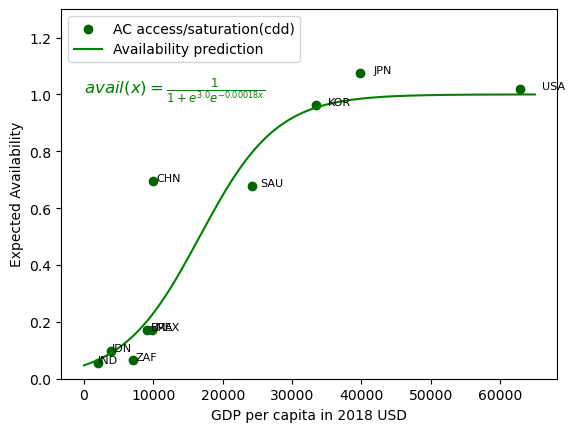

In [18]:
def avail_new(gdp):
    return (1/(1 + np.exp(av_a)* np.exp(av_b*gdp)))

# Plot availability curve and data points

plt.figure()
plt.scatter(ac_data['GDP'], ac_data['avail_pred_new'], label='AC access/saturation(cdd)', color='darkgreen')

gdp_x_fine = np.linspace(0, 65000, 1000)
plt.plot(gdp_x_fine, avail_new(gdp_x_fine), label='Availability prediction', color='green')
plt.text(0, 1., f'$avail(x) = \\frac{{1}}{{1 + e^{{{av_a:.1f}}}e^{{{av_b:.5f}x}}}}$', fontsize=12, color='green', fontweight='bold')
plt.xlabel('GDP per capita in 2018 USD')
plt.ylabel('Expected Availability')
plt.ylim(0, 1.3)
plt.legend(loc='upper left')

# Label points with country names
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['GDP'][i]*1.05, ac_data['avail_pred_new'][i]), fontsize=8)

plt.savefig('Figures/exposure_funct_analysis/availability_new.png', dpi=300)


In [22]:
ac_data

,ISO3,DD_mean,GDP,AC,sat_calc,avail_pred,avail_calc,sat_pred,sat_calc_new,avail_pred_new
0,BRA,2508.361929,9121.020092,0.16,0.991287,0.161406,0.357731,0.447263,0.931691,0.171731
1,CHN,533.091995,9905.406118,0.60,0.649792,0.923372,0.430824,1.392681,0.864846,0.693765
2,IDN,2405.041162,3902.661675,0.09,0.989430,0.090961,0.067492,1.333486,0.931688,0.096599
3,IND,2615.146210,1974.377730,0.05,0.992864,0.050359,0.032929,1.518420,0.931692,0.053666
4,JPN,481.315526,39751.133098,0.91,0.614189,1.481630,0.999989,0.910010,0.845411,1.076399
5,KOR,651.360792,33436.923065,0.86,0.719278,1.195643,0.999867,0.860115,0.894375,0.961565
6,MEX,1471.855206,9857.007487,0.16,0.939476,0.170308,0.426189,0.375420,0.931041,0.171851
7,SAU,3187.489303,24175.583124,0.63,0.997553,0.631545,0.995042,0.633139,0.931695,0.676187
8,USA,604.579562,62823.309438,0.90,0.693614,1.297551,1.000000,0.900000,0.884698,1.017297
9,ZAF,927.694056,7048.508112,0.06,0.832561,0.072067,0.198502,0.302263,0.922135,0.065066


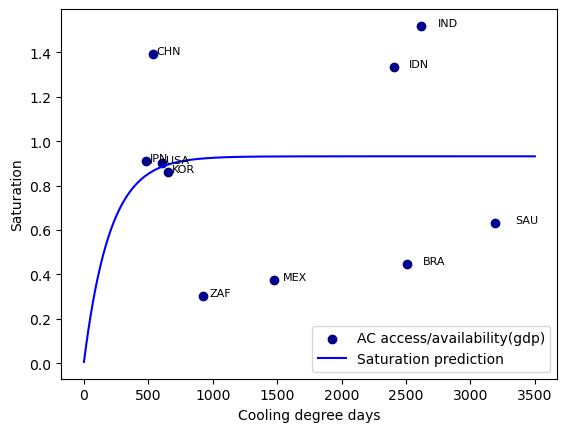

In [19]:
# Double check saturation
plt.figure()
cdd_x_fine = np.linspace(0, 3500, 1000)
plt.scatter(ac_data['DD_mean'], ac_data['sat_pred'], label='AC access/availability(gdp)', color='darkblue')
plt.plot(cdd_x_fine, saturation_new(cdd_x_fine), label='Saturation prediction', color='blue')
plt.xlabel('Cooling degree days')
plt.ylabel('Saturation')
# Label each point with country name
for i, txt in enumerate(ac_data['ISO3'].values):
    plt.annotate(txt, (ac_data['DD_mean'][i]*1.05, ac_data['sat_pred'][i]), fontsize=8)
plt.legend()
plt.savefig('Figures/exposure_funct_analysis/saturation_new.png', dpi=300)

In [20]:
def exposure_new(gdp, cdd):
    return (1 - avail_new(gdp)*saturation_new(cdd))

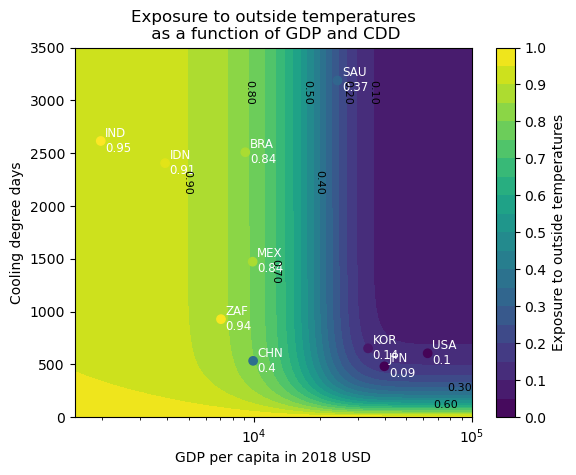

In [21]:
# Make a contour plot of penetration of air conditioning as a function of GDP per capita and cooling degree days
exposure_contour(exposure_new, ac_data, contour_lines=True,
                 name_tag='exposure_contour_new')